In [71]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import folium
import urllib.request, urllib.parse, urllib.error
from bs4 import BeautifulSoup
import ssl
import re
from matplotlib import pyplot as plt

#### We're getting the 140 neighbourhoods...

These are 140 neighbourhoods that the city has been divided into by the City of Toronto administration. Since they are different from the neighbourhoods assigned by postal code, both datasets will be used.

In [2]:
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

try:
    url = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto'
    html = urllib.request.urlopen(url, context = ctx).read()
    soup = BeautifulSoup(html, 'html.parser')
except urllib.error.HTTPError as err:
    print('***********', err.info())
    quit()
except Exception as err:    
    print(err)
    quit()

    
#wikitable.sortable.jquery-tablesorter    
print('************Starting to scan page...*********************')

ran_list = []
toronto_data_list = []


code_table =  soup.find_all("table",{"class":"wikitable sortable"})[1]

code_table_body = code_table.tbody.find_all('tr')


for char in code_table_body:
    res = char.find_all('td')
    if len(res) <= 0:
        pass
    else:
        cdn = res[0].text.strip()
        ngh = res[1].text.strip()
        borough = res[2].text.strip()
        covngh = res[3].text.strip()
        
        row = {'CDN number' : cdn, 'City-designated neighbourhood': ngh, 
               'Former city/borough': borough, 'Neighbourhoods covered': covngh}
        toronto_data_list.append(row)

toronto_data_140 = pd.DataFrame.from_dict(toronto_data_list)
toronto_data_140.head(20)
toronto_data_140.to_csv('toronto_data_140.csv')


************Starting to scan page...*********************


#### Getting the postal code data...

In [3]:
address_list = []

toronto_data_init = pd.read_csv('toronto_data.csv')
toronto_data_init.drop('Unnamed: 0', axis = 1, inplace = True)

for postal, bor, ngh in zip(toronto_data_init['Postal_Code'], toronto_data_init['Borough'], toronto_data_init['Neighbourhood']):
    resu = ngh.split(',')
    for val in resu:
        val = val.replace(')', ' ')
        val = val.strip() 
        row = {'Postal_Code': postal, 'Borough': bor, 'Neighbourhood': val}
        address_list.append(row)
        
tor_data = pd.DataFrame(address_list)
tor_data.to_csv('toronto_data_4.csv')

#### We get both datasets predownloaded for testing

In [23]:
toronto_data_140 = pd.read_csv('toronto_data_140.csv')
tor_data = pd.read_csv('toronto_data_4.csv')
toronto_data_140.drop('Unnamed: 0', axis = 1, inplace = True)

In [24]:
geo_coords = pd.read_csv('Geospatial_Coordinates.csv')
toronto_postal_data = pd.merge(tor_data, geo_coords, left_on = ['Postal_Code'], right_on = ['Postal Code'])
toronto_postal_data.drop(['Postal Code', 'Unnamed: 0'], axis = 1, inplace = True)


#### Showing both datasets 

In [25]:
toronto_postal_data.head()

,Postal_Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,Malvern,43.806686,-79.194353
1,M1B,Scarborough,Rouge,43.806686,-79.194353
2,M1C,Scarborough,Rouge Hill,43.784535,-79.160497
3,M1C,Scarborough,Port Union,43.784535,-79.160497
4,M1C,Scarborough,Highland Creek,43.784535,-79.160497


In [26]:
toronto_data_140.head()

,CDN number,City-designated neighbourhood,Former city/borough,Neighbourhoods covered
0,129,Agincourt North,Scarborough,Agincourt and Brimwood
1,128,Agincourt South-Malvern West,Scarborough,Agincourt and Malvern
2,20,Alderwood,Etobicoke,Alderwood
3,95,Annex,Old City of Toronto,The Annex and Seaton Village
4,42,Banbury-Don Mills,North York,Don Mills


In [8]:
addresses = []

rare_addresses = [
    {'Location': 'Blake-Jones', 'Latitude': 43.671400, 'Longitude': -79.336530}
    
]



for i in range(toronto_data_140.shape[0]):
    try:
# first we try geocoder to find the location of each neighbourhood
        ngh, bor, covngh = toronto_data_140.iloc[i,1], toronto_data_140.iloc[i,2], toronto_data_140.iloc[i,3]
        address = '{}, Toronto, Canada'.format(ngh)
        geolocator = Nominatim(user_agent='Final_Project_TBotN')
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        
    except AttributeError as err:
# if geocoder cannot find the location, we use the table we already have to get the data
        print('Found attribute error')
        try:
            r = toronto_data.loc[(toronto_data['Borough'].str.contains(ngh)) | (toronto_data['Borough'].str.contains(covngh)) | (toronto_data['Borough'] == bor)].iloc[0,]
            lat, lng = r[3] ,r[4]
        except:
# if the location cannot be found in both tables, the data is entered manually.
# Luckily, there aren't too many of these
            print('Can\'t find location in both tables.')
            for j in range(len(rare_addresses)):
                place = rare_addresses[j]['Location'] == ngh
                lat, lng = rare_addresses[j]['Latitude'], rare_addresses[j]['Longitude']
        
    row = {'Borough': bor, 'Location': address, 'Latitude': latitude, 
               'Longitude': longitude, 'Neighbourhoods covered': covngh}
    addresses.append(row)

toronto_data = pd.DataFrame(addresses)
#toronto_data.head(20)

Found attribute error
Found attribute error
Found attribute error
Found attribute error
Found attribute error
Can't find location in both tables.
Found attribute error
Found attribute error
Found attribute error
Found attribute error


KeyboardInterrupt: 

In [ ]:
toronto_data['Location'] = toronto_data['Location'].str.replace(', Toronto, Canada', '')

In [29]:
# Done so that data doesn't need to be downloaded repeatedly

toronto_data = pd.read_csv('tor_neighbourhood_locations.csv')
toronto_data.drop('Unnamed: 0', axis = 1, inplace = True)

In [30]:
toronto_data.head()

,Borough,Location,Latitude,Longitude,Neighbourhoods covered
0,Scarborough,Agincourt North,43.808038,-79.266439,Agincourt and Brimwood
1,Scarborough,Agincourt South-Malvern West,43.781969,-79.257689,Agincourt and Malvern
2,Etobicoke,Alderwood,43.601717,-79.545232,Alderwood
3,Old City of Toronto,Annex,43.670338,-79.407117,The Annex and Seaton Village
4,North York,Banbury-Don Mills,43.670338,-79.407117,Don Mills


Then we get the location of Toronto itself

In [31]:
toronto_address = 'Toronto, Canada'

geolocator = Nominatim(user_agent='explore_toronto')
location = geolocator.geocode(toronto_address)
t_latitude = location.latitude
t_longitude = location.longitude
print('The geograpical coordinate of Toronto, Canada are {}, {}.'.format(t_latitude, t_longitude))

The geograpical coordinate of Toronto, Canada are 43.6534817, -79.3839347.


In [32]:
toronto_map = folium.Map(location = [t_latitude, t_longitude], zoom_start = 10)

for lat, lng, neighbourhood, borough in zip(
    toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Location'], toronto_data['Borough']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#ff1493',
        fill=True,
        fill_color='#ff69b4',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  

### The 140 administrative neighbourhoods of Toronto

In [33]:
toronto_map

#### Moving on to the locations of child care centres...

In [40]:
child_care = pd.read_csv('Child care centres.csv')
child_care.drop('_id', axis = 1, inplace = True)
child_care['PCODE'] = child_care['PCODE'].str[:3]
child_care.fillna('None', inplace = True)
child_care.head()

,LOC_ID,LOC_NAME,AUSPICE,ADDRESS,PCODE,ward,PHONE,bldg_type,BLDGNAME,IGSPACE,TGSPACE,PGSPACE,KGSPACE,SGSPACE,TOTSPACE,subsidy,run_date,geometry
0,1013,Lakeshore Community Child Care Centre,Non Profit Agency,101 SEVENTH ST,M8V,3,(416) 394-7601,Public Elementary School,Seventh Street Public School,0,20,32,52,60,164,Y,06AUG21,"{u'type': u'Point', u'coordinates': (-79.50419..."
1,1014,Alternative Primary School Parent Group,Non Profit Agency,1100 SPADINA RD,M5N,8,(416) 322-5385,Public Elementary School,North Preparatory Public School,0,0,12,26,45,83,Y,06AUG21,"{u'type': u'Point', u'coordinates': (-79.42037..."
2,1015,Cardinal Leger Child Care Centre (Scarborough),Non Profit Agency,600 MORRISH RD,M1C,25,(416) 287-0578,Catholic Elementary School,Cardinal Leger Catholic School,0,10,16,26,50,102,Y,06AUG21,"{u'type': u'Point', u'coordinates': (-79.17546..."
3,1016,George Brown - Richmond Adelaide Childcare Centre,Non Profit Agency,130 ADELAIDE ST W,M5H,10,(416) 415-2453,Other,None,10,15,40,0,0,65,Y,06AUG21,"{u'type': u'Point', u'coordinates': (-79.38381..."
4,1017,Woodland Nursery School (Warden Woods Communit...,Non Profit Agency,1 FIRVALLEY CRT,M1L,20,(416) 694-1138x157,High Rise Apartment,None,0,10,16,0,0,26,Y,06AUG21,"{u'type': u'Point', u'coordinates': (-79.28102..."


In [35]:
child_care.shape

(1027, 18)

We check the number of centres via shape of table. There are 1027 childcare centres in Toronto.

Then we add boroughs to the childcare centres:

In [45]:
cc_b = pd.merge(child_care, toronto_postal_data, left_on = 'PCODE', right_on = 'Postal_Code')
cc_b.drop(['Latitude', 'Longitude', 'Postal_Code'], axis = 1, inplace = True)
cc_b.head()

,LOC_ID,LOC_NAME,AUSPICE,ADDRESS,PCODE,ward,PHONE,bldg_type,BLDGNAME,IGSPACE,TGSPACE,PGSPACE,KGSPACE,SGSPACE,TOTSPACE,subsidy,run_date,geometry,Borough,Neighbourhood
0,1013,Lakeshore Community Child Care Centre,Non Profit Agency,101 SEVENTH ST,M8V,3,(416) 394-7601,Public Elementary School,Seventh Street Public School,0,20,32,52,60,164,Y,06AUG21,"{u'type': u'Point', u'coordinates': (-79.50419...",Etobicoke,New Toronto
1,1013,Lakeshore Community Child Care Centre,Non Profit Agency,101 SEVENTH ST,M8V,3,(416) 394-7601,Public Elementary School,Seventh Street Public School,0,20,32,52,60,164,Y,06AUG21,"{u'type': u'Point', u'coordinates': (-79.50419...",Etobicoke,Mimico South
2,1013,Lakeshore Community Child Care Centre,Non Profit Agency,101 SEVENTH ST,M8V,3,(416) 394-7601,Public Elementary School,Seventh Street Public School,0,20,32,52,60,164,Y,06AUG21,"{u'type': u'Point', u'coordinates': (-79.50419...",Etobicoke,Humber Bay Shores
3,1059,Elder Tree Montessori,Commercial Agency,46 MIMICO AVE,M8V,3,(416) 255-4748,Commercial Building,Memorial Hall 1916-1918,0,10,14,0,0,24,N,06AUG21,"{u'type': u'Point', u'coordinates': (-79.49150...",Etobicoke,New Toronto
4,1059,Elder Tree Montessori,Commercial Agency,46 MIMICO AVE,M8V,3,(416) 255-4748,Commercial Building,Memorial Hall 1916-1918,0,10,14,0,0,24,N,06AUG21,"{u'type': u'Point', u'coordinates': (-79.49150...",Etobicoke,Mimico South


In [96]:
div_by_bor = (
  cc_b
  .groupby(['Borough'], as_index=False)
  .agg(Total=('PCODE', 'count'))
  .sort_values('Total', ascending=False)
)
    
div_by_bor.reset_index(drop = True)

,Borough,Total
0,Etobicoke,543
1,Scarborough,505
2,North York,382
3,Downtown Toronto,262
4,West Toronto,175
5,Central Toronto,122
6,EtobicokeNorthwest,108
7,York,101
8,East Toronto,99
9,East York,53


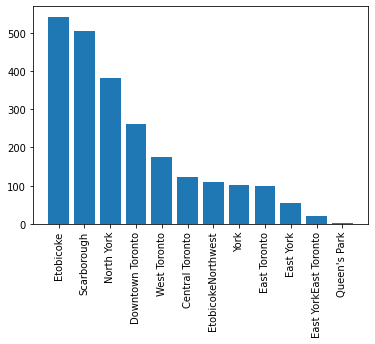

In [94]:
myplot = plt.bar(div_by_bor.iloc[:,0], div_by_bor.iloc[:,1])
plt.xticks(rotation = 90)
plt.show()
# PLEASE ADD LABELS!!!!!


By the above, we see that Etobicoke borough has the greatest number of childcare centres, while Queen's Park has the least. However, when we check the number of neighbourhoods Etobicoke has, we get the following result:

In [106]:
toronto_data_140.loc[toronto_data_140['Former city/borough'] == 'Etobicoke']['City-designated neighbourhood'].count()

20

In [104]:
toronto_data_140.loc[toronto_data_140['Former city/borough'] == 'Etobicoke']['City-designated neighbourhood']

2                              Alderwood
37              Edenbridge-Humber Valley
39                      Elms-Old Rexdale
41        Eringate-Centennial-West Deane
42                   Etobicoke West Mall
54              Humber Heights-Westmount
59            Islington-City Centre West
64         Kingsview Village-The Westway
65                        Kingsway South
73                           Long Branch
76                         Markland Wood
78                                Mimico
82     Mount Olive-Silverstone-Jamestown
85                           New Toronto
100                   Princess-Rosethorn
102                      Rexdale-Kipling
114                  Stonegate-Queensway
117         Thistletown-Beaumond Heights
124               West Humber-Clairville
131     Willowridge-Martingrove-Richview
Name: City-designated neighbourhood, dtype: object

On the other hand, if we check Queen's Park, we get:

In [112]:
print(toronto_data_140.loc[toronto_data_140['Former city/borough'] == "Queens's Park"]['City-designated neighbourhood'].count())
cc_b.loc[cc_b['Borough'] == "Queen's Park"]

0


,LOC_ID,LOC_NAME,AUSPICE,ADDRESS,PCODE,ward,PHONE,bldg_type,BLDGNAME,IGSPACE,TGSPACE,PGSPACE,KGSPACE,SGSPACE,TOTSPACE,subsidy,run_date,geometry,Borough,Neighbourhood
2369,13954,Queen's Park Child Care Centre,Non Profit Agency,7 QUEENS PARK CRES E,M7A,11,(416) 972-9979,Other,None,10,30,48,0,0,88,Y,06AUG21,"{u'type': u'Point', u'coordinates': (-79.38960...",Queen's Park,Ontario Provincial Government


The centre is not in a real neighbourhood, but falls within the 'neighbourhood' of the Ontario Provincial Government

To further refine our data, we split it into neighbourhoods:

In [113]:
div_by_ngh = (
  cc_b
  .groupby(['Borough', 'Neighbourhood'], as_index=False)
  .agg(Total=('PCODE', 'count'))
  .sort_values('Total', ascending=False)
)
    
div_by_ngh.reset_index(drop = True)

,Borough,Neighbourhood,Total
0,North York,Fairview,26
1,North York,Henry Farm,26
2,North York,Oriole,26
3,Scarborough,Agincourt North,23
4,Scarborough,Milliken,23
...,...,...,...
201,Downtown Toronto,King,2
202,Downtown Toronto,Richmond,2
203,Downtown Toronto,Garden District,1
204,Downtown Toronto,Ryerson,1


Now we see that the borough of North York has the greatest number of childcare centres by neighbourhood

In [ ]:
# Draw map of cccs

#### Then we read in data on family centres

In [36]:
com_prog = pd.read_csv('EarlyON Child and Family Centres.csv')
com_prog.drop('_id', axis = 1, inplace = True)
com_prog.head()

,loc_id,program,agency,address,phone,rundate,geometry
0,6197,Alexandra Park EarlyON Child and Family Centre,Alexandra Park Residents Association/Community...,105 Grange Crt,4166039603,06AUG21,"{u'type': u'Point', u'coordinates': (-79.39888..."
1,6199,Applegrove EarlyON Child and Family Centre,Applegrove Community Complex,60 Woodfield Rd,4164615392,06AUG21,"{u'type': u'Point', u'coordinates': (-79.32191..."
2,6200,Applegrove Connection EarlyON Child and Family...,Applegrove Community Complex,31 Eastwood Rd,4164615046,06AUG21,"{u'type': u'Point', u'coordinates': (-79.31814..."
3,6202,Birchmount Bluffs EarlyON Child and Family Centre,Birchmount Bluffs Neighbourhood Centre,93 Birchmount Rd,4163967599,06AUG21,"{u'type': u'Point', u'coordinates': (-79.26311..."
4,6209,St. Helen's EarlyON Child and Family Centre,College-Montrose Children's Place,66 Sheridan Ave,4168457223,06AUG21,"{u'type': u'Point', u'coordinates': (-79.43344..."


In [37]:
com_prog.shape

(262, 7)

We see that there are 262 family centres in Toronto 